<a href="https://colab.research.google.com/github/vikita87/tp-equipo-13/blob/main/N3_S4_S_Machine_Learning_Tradicional_Aprendizaje_Supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Tradicional - Aprendizaje Supervisado

## Caso de estudio: California Housing

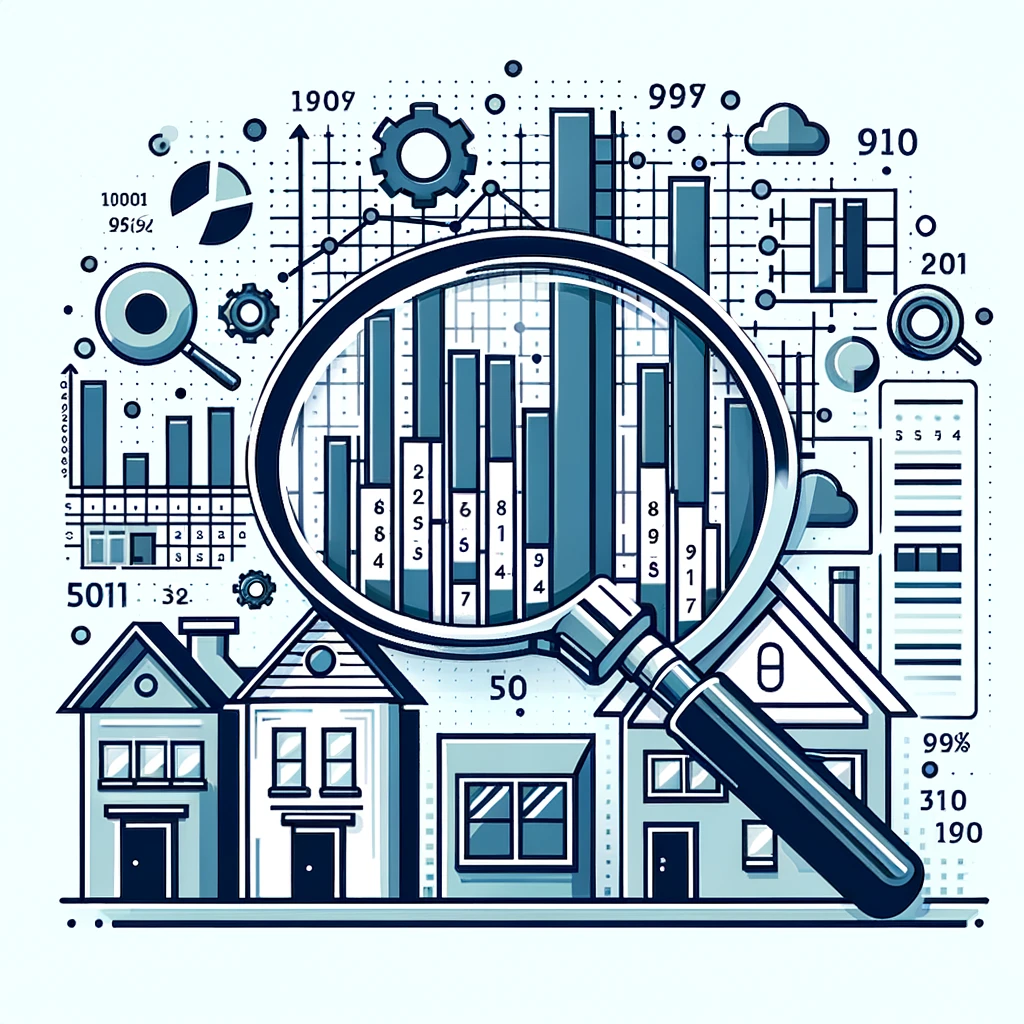

## Comparación de Modelos de Aprendizaje Supervisado

En esta notebook, analizaremos el rendimiento de tres modelos de aprendizaje supervisado:
- Regresión Lineal
- Modelos de Árbol: Random Forest / XGboost
- K-Nearest Neighbors (KNN)

Usaremos el California Housing Dataset para predecir el precio de las casas basándonos en diversas características. Cada modelo será evaluado y comparado utilizando el Mean Squared Error (MSE) como métrica principal.

## Importanción de dependencias y dataset

In [ ]:
# Importación de dependencias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# Cargar en Google Colab el archivo California_Housing_Prices.csv que figura en el aula virtual
# para descargar

df = pd.read_csv("California_Housing_Prices.csv")

Imagen de referencia
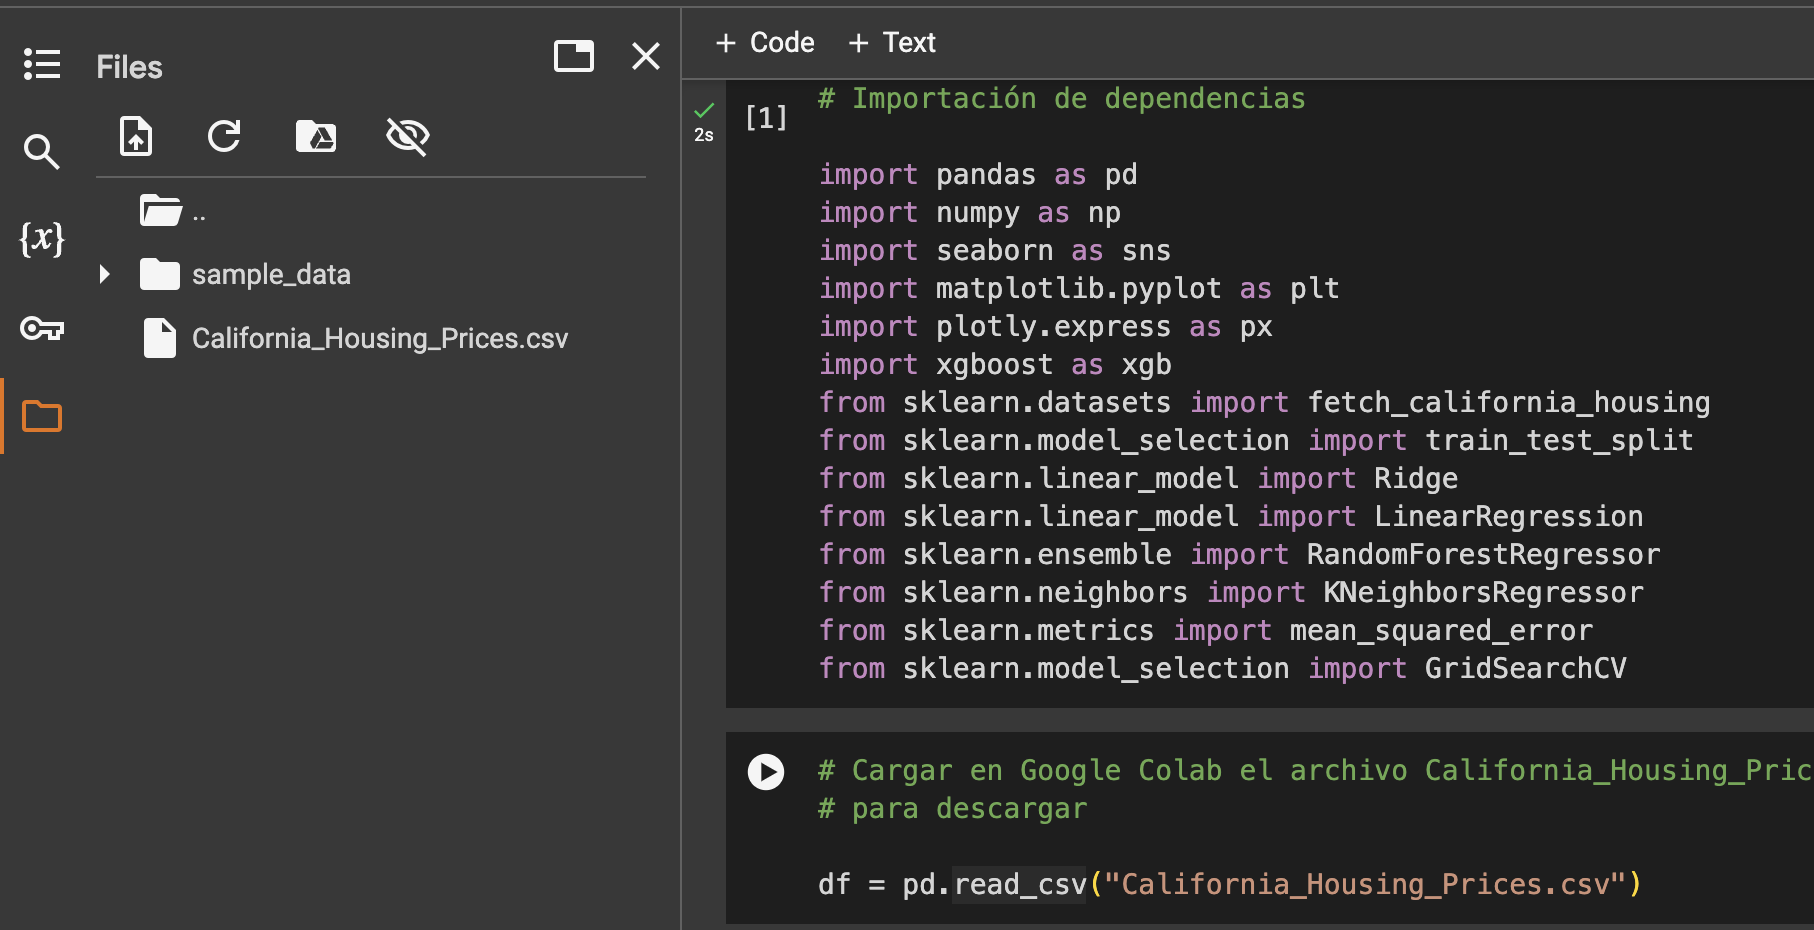

## Exploración Inicial de Datos

Vamos a echar un vistazo a los primeros registros del dataset para tener una idea de las características y la variable objetivo.

In [ ]:
# Mostrar las primeras filas del dataframe
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# Estadísticas descriptivas
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


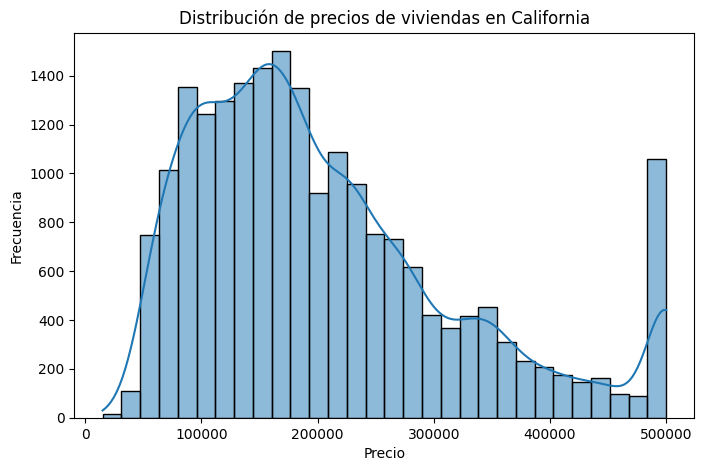

In [ ]:
# Visualización de la distribución de precios
plt.figure(figsize=(8, 5))
sns.histplot(df['median_house_value'], bins=30, kde=True)
plt.title('Distribución de precios de viviendas en California')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
fig = px.scatter(
    df,
    x="longitude",
    y="latitude",
    color="median_house_value",
    color_continuous_scale=px.colors.sequential.Plasma,  # Un esquema de color similar a 'coolwarm'
    labels={"median_house_value": "Valor Promedio de una casa"},  # Etiqueta personalizada para la leyenda de color
    title="Distribución geográfica del valor promedio de una casa"
)

fig.update_layout(coloraxis_colorbar=dict(title="Valor promedio"))
fig.show()

## Preprocesamiento de datos con manejo de valores nulos

Antes de entrenar nuestros modelos, necesitamos dividir los datos en conjuntos de entrenamiento y prueba.

In [ ]:
# Eliminar filas con valores NaN para entrenar todos los modelos
# Algunos lo requieren otros pueden manejar valores nulos

df = df.dropna()

In [ ]:
len(df) # Originalmente teníamos 20640 valores por lo que no eran tantos valores con NaN

20433

In [ ]:
# Definir las características (features) y la variable objetivo (price)
X = df.drop(['median_house_value','ocean_proximity'], axis=1)
y = df['median_house_value']

In [ ]:
# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dejar un valor fijo de random state nos garantiza la reproducibilidad del entrenamiento bajo los mismos datos.

### Manejo de Valores Nulos en Modelos de scikit-learn

El manejo de valores nulos es un aspecto crucial en el preprocesamiento de datos para aprendizaje automático. No todos los modelos en `scikit-learn` pueden manejar valores nulos de manera nativa. Aquí se detalla cuáles modelos pueden y cuáles no:

### Modelos que **No** Manejan Valores Nulos

La mayoría de los modelos en `scikit-learn` requieren que los valores nulos sean manejados (es decir, imputados o eliminados) antes del entrenamiento. Algunos ejemplos incluyen:

- **Modelos Lineales**: Como `LinearRegression`, `LogisticRegression`, etc. Estos modelos no pueden entrenarse con datos que incluyan valores `NaN`.
- **Máquinas de Soporte Vectorial (SVM)**: Tanto para clasificación (`SVC`) como para regresión (`SVR`).
- **K-Vecinos más Cercanos (KNN)**: Este modelo tampoco puede procesar `NaN` directamente.
- **Métodos basados en Árboles**: Incluyendo `DecisionTreeClassifier` y `DecisionTreeRegressor` de `scikit-learn` que no admiten valores nulos.

### Modelos que Manejan Valores Nulos

Algunos modelos avanzados y ensambladores pueden manejar valores nulos directamente durante el entrenamiento:

- **HistGradientBoostingClassifier y HistGradientBoostingRegressor**: Estos modelos de `scikit-learn` pueden manejar valores nulos de forma nativa. Utilizan técnicas como el entrenamiento de árboles basados en histogramas que pueden gestionar `NaN` sin imputación previa.

Es importante destacar que incluso cuando algunos modelos pueden manejar `NaN`, es esencial realizar un análisis detallado para entender la naturaleza de estos valores faltantes y cómo podrían influir en el rendimiento del modelo.

### Recomendaciones

Para los modelos que no manejan `NaN`, se recomienda utilizar técnicas de imputación como `SimpleImputer` o `IterativeImputer` de `scikit-learn`. Estas herramientas ofrecen diferentes estrategias para estimar los valores faltantes, como la media, mediana, o imputación más sofisticada basada en otros regresores.


# Entrenamiento con diversos modelos

## Modelo de Regresión Lineal

La regresión lineal es un método estadístico que intenta modelar la relación entre una variable continua (dependiente) y una o más variables independientes ajustando una ecuación lineal a los datos observados.

In [ ]:
# Crear y entrenar el modelo de Regresión Lineal
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predicciones y cálculo de MSE
y_pred_lin = lin_model.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"MSE de Regresión Lineal: {mse_lin:.4f}")

# La métrica MSE puede ser compleja de interpretar
# El ser valores tan grandes y elevarlos al cuadrado se complejiza -> Puede ser una oportunidad para normalizar o estandarizar

MSE de Regresión Lineal: 4921881237.6282


## Modelo Random Forest

Random Forest es un método de ensamble que construye múltiples árboles de decisión y fusiona sus predicciones para mejorar la precisión general y controlar el overfitting.

In [ ]:
# Crear y entrenar el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones y cálculo de MSE
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"MSE de Random Forest: {mse_rf:.4f}")

MSE de Random Forest: 2408424402.3732


## Modelo XGBoost

XGBoost es un algoritmo de aprendizaje automático avanzado conocido por su rendimiento y precisión en competiciones de modelado predictivo. Una de las características destacadas de XGBoost es su capacidad para manejar directamente valores nulos o faltantes en los datos.

### Ventajas del Manejo de Nulos en XGBoost

- **Simplicidad en Preprocesamiento**: No es necesario realizar una etapa de imputación de valores nulos, lo que simplifica el proceso de preparación de los datos.
- **Conservación de Información**: Al permitir que el modelo maneje los nulos, se conserva la información sobre la ausencia de datos, que podría ser útil para hacer predicciones.
- **Flexibilidad**: XGBoost puede ser más efectivo en situaciones donde los valores nulos tienen significado en el contexto del problema.

In [ ]:
# Crear y entrenar el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
xgb_model.fit(X_train, y_train)

# Predicciones y cálculo de MSE
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"MSE de XGBoost: {mse_xgb:.4f}")

MSE de XGBoost: 2403489962.6951


## Modelo K-Nearest Neighbors (KNN)

K-Nearest Neighbors es un algoritmo de aprendizaje basado en instancia que clasifica los nuevos casos basándose en una medida de similitud (distancia) con casos conocidos.

In [ ]:
# Crear y entrenar el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predicciones y cálculo de MSE
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"MSE de KNN: {mse_knn:.4f}")

MSE de KNN: 10091759678.6073


# Evaluación con otra métrica: MAPE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Para Regresión Lineal
y_pred_lin = lin_model.predict(X_test)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)
print(f"MAPE de Regresión Lineal: {mape_lin:.2f}%")

# Para Random Forest
y_pred_rf = rf_model.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"MAPE de Random Forest: {mape_rf:.2f}%")

# Para XGboost
y_pred_xgb = xgb_model.predict(X_test)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"MAPE de XGBoost: {mape_xgb:.2f}%")

# Para K-Nearest Neighbors
y_pred_knn = knn_model.predict(X_test)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
print(f"MAPE de KNN: {mape_knn:.2f}%")

# Esta métrica porcentual es mucho más clara

MAPE de Regresión Lineal: 30.27%
MAPE de Random Forest: 17.43%
MAPE de XGBoost: 17.89%
MAPE de KNN: 51.42%


# Búsqueda de hiperparámetros para mejorar las métricas

## Optimización de Hiperparámetros - Regresión Lineal

### Uso de GridSearchCV en la Regresión Lineal

La Regresión Lineal es un modelo estadístico que intenta predecir una relación lineal entre las variables dependientes e independientes. Aunque es un modelo relativamente simple con pocos hiperparámetros, existen variantes de regresión lineal como Ridge y Lasso que incluyen parámetros de regularización. Estos parámetros controlan el grado de penalización aplicada a los coeficientes, y su optimización puede ayudar a prevenir el sobreajuste o mejorar la capacidad del modelo para generalizar.

### ¿Es útil GridSearchCV para la Regresión Lineal?

`GridSearchCV` se utiliza comúnmente para la optimización de hiperparámetros en modelos de aprendizaje automático. Para la regresión lineal estándar, la utilidad de `GridSearchCV` es limitada debido a la falta de hiperparámetros complejos. Sin embargo, en variantes regularizadas como Ridge o Lasso, que tienen hiperparámetros como el coeficiente de regularización `alpha`, `GridSearchCV` puede ser muy útil para encontrar el valor óptimo de `alpha`.

### Implementación en scikit-learn

Aquí hay un ejemplo de cómo se podría usar `GridSearchCV` con la regresión de Ridge:

In [ ]:
# Definir el espacio de parámetros para la búsqueda de cuadrícula
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Instanciar el modelo de Ridge
ridge = Ridge()

# Instanciar GridSearchCV con el modelo y el espacio de parámetros
grid_ridge = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error')

# Ajustar GridSearchCV
grid_ridge.fit(X_train, y_train)

# Ver los mejores parámetros para Ridge Regression
print(f"Mejores parámetros para Rigde Regression: {grid_ridge.best_params_}")

Mejores parámetros para Rigde Regression: {'alpha': 1}


In [ ]:
# Métricas de evaluación para Ridge Regression

y_pred_ridge = grid_ridge.predict(X_test)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)
print(f"Mejor score (MAPE) de Ridge: {mape_ridge:.2f}%")
print(f"Mejor score (MSE) de Ridge: {-grid_ridge.best_score_}")

Mejor score (MAPE) de Ridge: 30.27%
Mejor score (MSE) de Ridge: 4853551346.923348


### Razón para Utilizar neg_mean_squared_error

**Maximización en lugar de Minimización:**

Scikit-learn siempre intenta maximizar la función de puntuación. Sin embargo, para muchas métricas de regresión, como el MSE, menores valores indican mejor rendimiento. Al utilizar el negativo del MSE (neg_mean_squared_error), convertimos el problema en uno de maximización, donde un "mayor" score es mejor. Esto permite a scikit-learn utilizar de manera uniforme la regla de maximización para seleccionar los mejores modelos.

Utilizar el negativo del MSE simplifica la implementación de la validación cruzada y la búsqueda de parámetros, ya que no se necesita ajustar el código para tratar algunas métricas de manera diferente (algunas requiriendo maximización, otras minimización).

## Optimización Hiperparámetros - Random Forest

In [ ]:
# Definir un diccionario de parámetros para Random Forest para la búsqueda de cuadrícula
param_grid_rf = {
    'n_estimators': [200, 300],  # Número de árboles
    'max_depth': [10, 20],  # Máxima profundidad de los árboles
}

# Instanciar el modelo Random Forest
rf = RandomForestRegressor(random_state=42)

# Instanciar el GridSearchCV con el modelo Random Forest y el diccionario de parámetros
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Ajustar el GridSearchCV
grid_rf.fit(X_train, y_train)

# Ver los mejores parámetros para Random Forest
print(f"Mejores parámetros para Random Forest: {grid_rf.best_params_}")

Mejores parámetros para Random Forest: {'max_depth': 20, 'n_estimators': 300}


In [ ]:
# Métricas de evaluación para Random Forest

y_pred_rf = grid_rf.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Mejor score (MAPE) de Random Forest: {mape_rf:.2f}%")
print(f"Mejor score (MSE) de Random Forest: {-grid_rf.best_score_}")

Mejor score (MAPE) de Random Forest: 17.45%
Mejor score (MSE) de Random Forest: 2423468310.472737


## Optimización Hiperparámtros - XGBoost

In [ ]:
# Definir un diccionario de parámetros para XGBoost para la búsqueda de cuadrícula

param_grid_xgb = {
    'n_estimators': [100, 200],  # Número de árboles
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
    #'max_depth': [3, 4, 5],  # Máxima profundidad de los árboles
    #'colsample_bytree': [0.6, 0.8, 1.0],  # Fracción de columnas a utilizar por árbol
    #'subsample': [0.6, 0.8, 1.0]  # Fracción de muestras a utilizar por árbol
}

# Instanciar el modelo XGBoost
xgb_model_hip = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Instanciar el GridSearchCV con el modelo XGBoost y el diccionario de parámetros
grid_xgb = GridSearchCV(xgb_model_hip, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Ajustar el GridSearchCV
grid_xgb.fit(X_train, y_train)

# Ver los mejores parámetros de XGBoost
print("Mejores parámetros para XGBoost:", grid_xgb.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros para XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}


In [ ]:
# Métricas de evaluación para XGBoost

y_pred_xgb = grid_xgb.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"Mejor score (MAPE) de XGboost: {mape_rf:.2f}%")
print(f"Mejor score (MSE) de XGboost: {-grid_xgb.best_score_}")

Mejor score (MAPE) de XGboost: 17.41%
Mejor score (MSE) de XGboost: 2207359077.5910225


## Optimización Hiperparámetros - KNN

In [ ]:
# Definir el modelo y los parámetros para el grid search
knn = KNeighborsRegressor()
params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}

#
grid_knn = GridSearchCV(knn, params, cv=5, scoring='neg_mean_squared_error')

# Ajustar el GridSearchCV
grid_knn.fit(X_train, y_train)

# Ver los mejores parámetros para knn
print("Mejores parámetros:", grid_knn.best_params_)

Mejores parámetros: {'n_neighbors': 11, 'weights': 'distance'}


In [ ]:
# Métricas de evaluación para K-Nearest Neighbors

y_pred_knn = grid_knn.predict(X_test)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
print(f"Mejor score (MAPE) de KNN: {mape_knn:.2f}%")
print(f"Mejor score (MSE) de KNN: {-grid_knn.best_score_}")

Mejor score (MAPE) de KNN: 50.40%
Mejor score (MSE) de KNN: 9147872640.991543


### Comparativa de métricas de modelos luego de optimización de hiperparámetros

In [ ]:
# Para Regresión Lineal
y_pred_lin = lin_model.predict(X_test)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)
print(f"MAPE de Regresión Lineal: {mape_lin:.2f}%")

# Para Ridge Regression
y_pred_lin = lin_model.predict(X_test)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)
print(f"MAPE de Ridge Regresión: {mape_lin:.2f}%")

# Para Random Forest
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_opt = grid_rf.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mape_rf_opt = mean_absolute_percentage_error(y_test, y_pred_rf_opt)
print(f"MAPE de Random Forest: {mape_rf:.2f}%")
print(f"MAPE de Random Forest Optimizado: {mape_rf:.2f}%")

# Para XGboost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_opt = grid_xgb.predict(X_test)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mape_xgb_opt = mean_absolute_percentage_error(y_test, y_pred_xgb_opt)
print(f"MAPE de XGBoost: {mape_xgb:.2f}%")
print(f"MAPE de XGBoost Optimizado: {mape_xgb_opt:.2f}%")

# Para K-Nearest Neighbors
y_pred_knn = knn_model.predict(X_test)
y_pred_knn_opt = grid_knn.predict(X_test)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
mape_knn_opt = mean_absolute_percentage_error(y_test, y_pred_knn_opt)
print(f"MAPE de KNN: {mape_knn:.2f}%")
print(f"MAPE de KNN Optimizado: {mape_knn_opt:.2f}%")

MAPE de Regresión Lineal: 30.27%
MAPE de Ridge Regresión: 30.27%
MAPE de Random Forest: 17.43%
MAPE de Random Forest Optimizado: 17.43%
MAPE de XGBoost: 17.89%
MAPE de XGBoost Optimizado: 17.41%
MAPE de KNN: 51.42%
MAPE de KNN Optimizado: 50.40%


# ¿Qué pasa si entrenamos en base a esta métrica?

## Definición de una métrica

In [ ]:
from sklearn.metrics import make_scorer

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

## GridSearch - Random Forest - Métrica MAPE

In [ ]:
# Definir el modelo y los parámetros para el grid search
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],  # Número de árboles
    'max_depth': [4, 6, 10],  # Máxima profundidad de los árboles
}

# Realizar el grid search con el MAPE como métrica
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring=mape_scorer, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Ver los mejores parámetros y el mejor score del grid search
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)
print("Mejor métrica (MAPE):", -grid_search_rf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros para Random Forest: {'max_depth': 10, 'n_estimators': 200}
Mejor métrica (MAPE): 20.220355444315892


## GridSearch - XGBoost - Métrica MAPE

In [ ]:
# Definir un diccionario de parámetros para XGBoost para la búsqueda de cuadrícula

param_grid_xgb = {
    'n_estimators': [100, 200],  # Número de árboles
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
    #'max_depth': [3, 4, 5],  # Máxima profundidad de los árboles
    #'colsample_bytree': [0.6, 0.8, 1.0],  # Fracción de columnas a utilizar por árbol
    #'subsample': [0.6, 0.8, 1.0]  # Fracción de muestras a utilizar por árbol
}

# Instanciar el modelo XGBoost
xgb_model_opt = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Instanciar el GridSearchCV con el modelo XGBoost y el diccionario de parámetros
grid_xgb = GridSearchCV(xgb_model_opt, param_grid_xgb, cv=5, scoring=mape_scorer, verbose=1)

# Ajustar el GridSearchCV
grid_xgb.fit(X_train, y_train)

# Ver los mejores parámetros de XGBoost
print("Mejores parámetros para XGBoost:", grid_xgb.best_params_)
print("Mejor métrica (MAPE):", -grid_xgb.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros para XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}
Mejor métrica (MAPE): -17.466344092781334


## GridSearch - KNN - Métrica MAPE



In [ ]:
# Definir el modelo y los parámetros para el grid search
model = KNeighborsRegressor()
params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}

# Realizar el grid search con el MAPE como métrica
grid_search = GridSearchCV(model, params, cv=5, scoring=mape_scorer)
grid_search.fit(X_train, y_train)

# Ver los mejores parámetros y el mejor score del grid search
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación (MAPE):", -grid_search.best_score_)

Mejores parámetros: {'n_neighbors': 11, 'weights': 'distance'}
Mejor puntuación (MAPE): 49.511533831341595


## Comparativa final: Optimización de hiperparámetros con MAPE

In [ ]:
# Para Regresión Lineal
y_pred_lin = lin_model.predict(X_test)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)
print(f"MAPE de Regresión Lineal: {mape_lin:.2f}%")

# Para Ridge Regression
y_pred_lin = lin_model.predict(X_test)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)
print(f"MAPE de Ridge Regresión: {mape_lin:.2f}%")

# Para Random Forest
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_opt = grid_rf.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mape_rf_opt = mean_absolute_percentage_error(y_test, y_pred_rf_opt)
print(f"MAPE de Random Forest: {mape_rf:.2f}%")
print(f"MAPE de Random Forest Optimizado: {mape_rf:.2f}%")

# Para XGboost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_opt = grid_xgb.predict(X_test)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mape_xgb_opt = mean_absolute_percentage_error(y_test, y_pred_xgb_opt)
print(f"MAPE de XGBoost: {mape_xgb:.2f}%")
print(f"MAPE de XGBoost Optimizado: {mape_xgb_opt:.2f}%")

# Para K-Nearest Neighbors
y_pred_knn = knn_model.predict(X_test)
y_pred_knn_opt = grid_knn.predict(X_test)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
mape_knn_opt = mean_absolute_percentage_error(y_test, y_pred_knn_opt)
print(f"MAPE de KNN: {mape_knn:.2f}%")
print(f"MAPE de KNN Optimizado: {mape_knn_opt:.2f}%")

MAPE de Regresión Lineal: 30.27%
MAPE de Ridge Regresión: 30.27%
MAPE de Random Forest: 17.43%
MAPE de Random Forest Optimizado: 17.43%
MAPE de XGBoost: 17.89%
MAPE de XGBoost Optimizado: 17.41%
MAPE de KNN: 51.42%
MAPE de KNN Optimizado: 50.40%


## Influencia de la métrica de evaluación en la selección de modelos

La elección de la métrica de evaluación en el aprendizaje automático no solo influye en cómo interpretamos el rendimiento de un modelo, sino que también puede guiar el proceso de selección y optimización del modelo durante la validación cruzada y la búsqueda de hiperparámetros.

### **Impacto en la Optimización de Hiperparámetros**

- **Random Forest y KNN**: Para modelos como Random Forest y KNN, que involucran una variedad de hiperparámetros (como la profundidad del árbol, el número de estimadores, o el número de vecinos), la métrica de evaluación seleccionada puede alterar significativamente los resultados de la optimización de hiperparámetros. Elegir una métrica como la exactitud (`accuracy`) frente a la puntuación F1 puede llevar a la selección de un modelo que privilegie la precisión general frente al equilibrio entre la precisión y la recuperación, especialmente en conjuntos de datos desequilibrados.

- **Regresión Lineal y Ridge**: En el caso de modelos de regresión como la regresión lineal y Ridge, donde los parámetros no ajustan complejidades del modelo sino que controlan la regularización (en el caso de Ridge), la métrica de evaluación aún guía cómo se valoran diferentes configuraciones durante la validación cruzada. Por ejemplo, optimizar para el error cuadrático medio (MSE) versus el error absoluto medio (MAE) puede afectar la selección del coeficiente de regularización en Ridge, donde MSE puede ser más sensible a los valores atípicos.

### **Selección de métricas adecuadas**

Es crucial seleccionar métricas que reflejen los objetivos específicos del análisis y las características del conjunto de datos. Por ejemplo:

- **Balance entre Clases**: En tareas con clases desbalanceadas, métricas como AUC-ROC o la puntuación F1 son preferibles sobre la exactitud, ya que consideran tanto la tasa de falsos positivos como la capacidad de identificar correctamente las clases positivas.

- **Sensibilidad a Valores Atípicos**: En regresión, si el conjunto de datos contiene valores atípicos significativos, el MSE podría llevar a un modelo que se vea excesivamente influenciado por estos, mientras que el MAE proporcionaría una medida más robusta del error típico.

La métrica de evaluación juega un papel crucial no solo en la interpretación del rendimiento de los modelos, sino también en la selección y optimización de los mismos durante el entrenamiento. Se debe poner cuidadosa consideración en la elección de la métrica para asegurar que el modelo final cumpla con las necesidades prácticas y teóricas del problema de aprendizaje automático a resolver.


# Conclusiones

El proceso de selección y optimización de modelos de Machine Learning (ML) puede ser complejo y está fuertemente influenciado por las características específicas de los datos con los que se trabaja. Aquí hay algunas conclusiones clave y mejores prácticas para trabajar con modelos de ML tradicional:

## Depende de los datos

- **Características de los Datos**: La elección del modelo a menudo depende de la naturaleza de los datos. Por ejemplo, algunos modelos manejan mejor las características categóricas, otros son más adecuados para datos numéricos continuos.
- **Distribución de los Datos**: La distribución y la escala de los datos pueden afectar significativamente el rendimiento del modelo. La normalización o estandarización puede ser necesaria para algunos algoritmos.
- **Dimensionalidad**: Modelos diferentes manejan de manera variada el número de características. Algunos modelos, como los basados en árboles, son menos susceptibles a la maldición de la dimensionalidad que otros, como K-NN.

## Optimización de Hiperparámetros

- **Importancia de la Ajuste Fino**: La optimización de hiperparámetros puede mejorar significativamente el rendimiento de un modelo. Herramientas como GridSearchCV o RandomizedSearchCV pueden ser útiles para explorar el espacio de hiperparámetros de manera sistemática.
- **Equilibrio entre Sesgo y Varianza**: Ajustar los hiperparámetros también puede ayudar a manejar el equilibrio entre sesgo y varianza, crucial para evitar el sobreajuste y el subajuste.

## Elección de la métrica adecuada

- **Alineación con Objetivos del Negocio**: La métrica de evaluación debe alinearse con los objetivos del negocio y las particularidades del problema. Por ejemplo, en problemas de clasificación desbalanceada, precision, recall o el área bajo la curva ROC pueden ser más informativos que la precisión.
- **Interpretación de Métricas**: Es esencial entender lo que cada métrica está realmente evaluando y cómo se relaciona con el problema en cuestión.

## Gestión de valores nulos

- **Influencia en el Modelo**: No todos los modelos pueden manejar valores nulos de forma nativa. Es importante entender cómo cada modelo gestiona, o no, los valores nulos.
- **Estrategias de Imputación**: La imputación de valores nulos puede afectar los resultados del modelo. La elección de la estrategia de imputación (media, mediana, k-vecinos más cercanos, etc.) debe considerar la naturaleza de los datos y del problema.

## En resumen

Probar diferentes modelos y técnicas es esencial para encontrar la mejor solución para un problema específico de ML. Sin embargo, una comprensión profunda de los datos, una cuidadosa gestión de los valores nulos, una elección adecuada de métricas y una optimización efectiva de los hiperparámetros son igualmente cruciales para el éxito de los proyectos de ML. En última instancia, no hay un "mejor" modelo universal; la mejor elección depende de las características específicas del conjunto de datos y del contexto del problema.